<a href="https://colab.research.google.com/github/falseywinchnet/PyITD/blob/main/AFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accumulator Fourier Transform: Question. Is it possible for us to decompose the fourier transform into a series of harmonically overlapping indexing at value? and as a result, can we rapidly perform some transposing and copying into scratch memory, and rapidly integrate over series of values that are consecutive in that we are essentially performing the FFT, but instead of doing so by the use of accumulators in butterfly space, we instead essentially roll out the carpet, duplicate our data the minimum number of times, using slicing, to create an alternative path through phase space that allows us to much more effectively vectorize the operations ? Suppose that we accepted a tradeoff in that this transform would be less efficient than the FFT, but more than the DFT, like the FFT it is an attempt to find the sort order internally, using overlapping harmonics and temporary storage, and, just like how the fft is related to sorting(and optimal) we can approach optimality but surrender some of it in order to get better contigious operations and sequential accumulation. This could be faster than the FFT- we can reason that iti s quick to multiply a bunch of numbers in a an array by just one coefficient, and then repeatedly sum them up by parts and add them together. if you decide to poke aroud with this and get somewhere, HMU

In [ ]:
import numpy as np

N = 512
k = np.arange(N)[:, np.newaxis]  # frequency bins
n = np.arange(N)                 # time indices

# Generate the real (cosine) parts
real_parts = np.cos(2 * np.pi * k * n / N)
# Generate the imaginary (sine) parts
imag_parts = -np.sin(2 * np.pi * k * n / N)

# Stack them vertically and round to 8 decimals
full_matrix = np.round(np.vstack([real_parts, imag_parts]), decimals=10)

# Let's see how many unique values we actually have
unique_values = np.unique(full_matrix)
print(f"Number of unique values after rounding: {len(unique_values)}")

Number of unique values after rounding: 257


In [ ]:
import numpy as np
from sympy import Symbol

# Using our existing full_matrix
unique_values = np.unique(full_matrix)
# Create a mapping of value -> symbol
value_to_symbol = {val: Symbol(f'v_{i}') for i, val in enumerate(unique_values)}

# Convert our numerical matrix to symbolic
symbolic_matrix = np.empty(full_matrix.shape, dtype=object)
for i in range(full_matrix.shape[0]):
    for j in range(full_matrix.shape[1]):
        symbolic_matrix[i,j] = value_to_symbol[full_matrix[i,j]]

In [ ]:
def find_harmonics(k, max_freq=512):
    """Find all harmonic frequencies of k up to max_freq"""
    harmonics = []
    n = 2
    while k * n < max_freq:
        harmonics.append(k * n)
        n += 1
    return harmonics

def compute_overlap(symbolic_matrix, k1, k2):
    """Compute overlap between two frequency bins"""
    # Get both real and imaginary parts
    bin1_real = symbolic_matrix[k1, :]
    bin1_imag = symbolic_matrix[k1 + 512, :]
    bin2_real = symbolic_matrix[k2, :]
    bin2_imag = symbolic_matrix[k2 + 512, :]

    # Find common symbols
    symbols1 = set(list(bin1_real) + list(bin1_imag))
    symbols2 = set(list(bin2_real) + list(bin2_imag))

    return len(symbols1.intersection(symbols2))

# Let's analyze first few fundamental frequencies
for k in range(1, 10):  # Start with small k to see pattern clearly
    harmonics = find_harmonics(k)
    print(f"\nFundamental frequency {k} harmonics:")
    for h in harmonics[:5]:  # Look at first 5 harmonics
        overlap = compute_overlap(symbolic_matrix, k, h)
        print(f"  Harmonic {h}: {overlap} shared symbols")


Fundamental frequency 1 harmonics:
  Harmonic 2: 129 shared symbols
  Harmonic 3: 257 shared symbols
  Harmonic 4: 65 shared symbols
  Harmonic 5: 257 shared symbols
  Harmonic 6: 129 shared symbols

Fundamental frequency 2 harmonics:
  Harmonic 4: 65 shared symbols
  Harmonic 6: 129 shared symbols
  Harmonic 8: 33 shared symbols
  Harmonic 10: 129 shared symbols
  Harmonic 12: 65 shared symbols

Fundamental frequency 3 harmonics:
  Harmonic 6: 129 shared symbols
  Harmonic 9: 257 shared symbols
  Harmonic 12: 65 shared symbols
  Harmonic 15: 257 shared symbols
  Harmonic 18: 129 shared symbols

Fundamental frequency 4 harmonics:
  Harmonic 8: 33 shared symbols
  Harmonic 12: 65 shared symbols
  Harmonic 16: 17 shared symbols
  Harmonic 20: 65 shared symbols
  Harmonic 24: 33 shared symbols

Fundamental frequency 5 harmonics:
  Harmonic 10: 129 shared symbols
  Harmonic 15: 257 shared symbols
  Harmonic 20: 65 shared symbols
  Harmonic 25: 257 shared symbols
  Harmonic 30: 129 shared 

In [ ]:
def create_accumulator_group(k):
   """Create accumulator group for fundamental k and its harmonics"""
   harmonics = find_harmonics(k)
   overlaps = [(h, compute_overlap(symbolic_matrix, k, h)) for h in harmonics]

   # Sort by overlap amount to identify highest reuse potential
   sorted_overlaps = sorted(overlaps, key=lambda x: x[1], reverse=True)

   # Group by overlap amount
   groups = {}
   for harmonic, overlap in sorted_overlaps:
       if overlap not in groups:
           groups[overlap] = []
       groups[overlap].append(harmonic)

   return groups

# Let's examine a few odd fundamentals
for k in [1,3,5,7,9]:
   groups = create_accumulator_group(k)
   print(f"\nFundamental {k} accumulator groups:")
   for overlap, harmonics in groups.items():
       print(f"  Overlap {overlap}: frequencies {harmonics}")


Fundamental 1 accumulator groups:
  Overlap 257: frequencies [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99, 101, 103, 105, 107, 109, 111, 113, 115, 117, 119, 121, 123, 125, 127, 129, 131, 133, 135, 137, 139, 141, 143, 145, 147, 149, 151, 153, 155, 157, 159, 161, 163, 165, 167, 169, 171, 173, 175, 177, 179, 181, 183, 185, 187, 189, 191, 193, 195, 197, 199, 201, 203, 205, 207, 209, 211, 213, 215, 217, 219, 221, 223, 225, 227, 229, 231, 233, 235, 237, 239, 241, 243, 245, 247, 249, 251, 253, 255, 257, 259, 261, 263, 265, 267, 269, 271, 273, 275, 277, 279, 281, 283, 285, 287, 289, 291, 293, 295, 297, 299, 301, 303, 305, 307, 309, 311, 313, 315, 317, 319, 321, 323, 325, 327, 329, 331, 333, 335, 337, 339, 341, 343, 345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373, 375, 377, 379, 381, 383, 385, 387, 389, 391, 393, 395, 397, 

In [ ]:
def sort_symbols_by_frequency(symbolic_matrix):
    # Create dictionary of symbol -> list of (freq_bin, real/imag) appearances
    symbol_locations = {}

    # First scan - map where each symbol appears
    for i in range(512):  # frequency bins
        # Real part
        for s in symbolic_matrix[i,:]:
            if s not in symbol_locations:
                symbol_locations[s] = []
            symbol_locations[s].append((i, 'real'))
        # Imaginary part
        for s in symbolic_matrix[i+512,:]:
            if s not in symbol_locations:
                symbol_locations[s] = []
            symbol_locations[s].append((i, 'imag'))

    # Sort symbols by number of appearances
    sorted_symbols = sorted(symbol_locations.items(),
                          key=lambda x: len(x[1]),
                          reverse=True)

    return sorted_symbols

symbols = sort_symbols_by_frequency(symbolic_matrix)


In [ ]:
def create_accumulation_paths(symbolic_matrix):
    symbol_paths = {}

    # For each frequency bin, track its symbol chain
    for i in range(512):
        bin_symbols = set()
        # Get both real and imaginary symbols
        bin_symbols.update(symbolic_matrix[i,:])
        bin_symbols.update(symbolic_matrix[i+512,:])

        # Find harmonically related bins that share symbols
        harmonics = [j for j in range(i+1, 512) if j % i == 0] if i > 0 else []

        # Create path through shared symbols
        symbol_paths[i] = {
            'symbols': bin_symbols,
            'harmonics': harmonics,
            'shared_symbols': {}
        }

        # Track shared symbols with each harmonic
        for h in harmonics:
            h_symbols = set()
            h_symbols.update(symbolic_matrix[h,:])
            h_symbols.update(symbolic_matrix[h+512,:])
            symbol_paths[i]['shared_symbols'][h] = bin_symbols.intersection(h_symbols)

    return symbol_paths

symbol_paths = create_accumulation_paths(symbolic_matrix)

In [ ]:
def create_sub_accumulators(symbol_paths):
   # Extract numeric index from symbol name (v_n -> n)
   def get_symbol_index(symbol):
       return int(str(symbol).split('_')[1])

   accumulators = {}
   for freq, path_info in symbol_paths.items():
       for harmonic, shared in path_info['shared_symbols'].items():
           if shared:  # if there are shared symbols
               # Convert symbols to their numeric indices for the key
               indices = tuple(sorted(get_symbol_index(s) for s in shared))
               if indices not in accumulators:
                   accumulators[indices] = {'freqs': set(), 'symbols': shared}
               accumulators[indices]['freqs'].update([freq, harmonic])

   return accumulators

sub_accumulators = create_sub_accumulators(symbol_paths)

In [ ]:
def create_sub_accumulators(symbol_paths):
    def get_symbol_index(symbol):
        return int(str(symbol).split('_')[1])

    # Create position lookup once
    symbol_positions = {}  # symbol_idx -> list of (freq, real/imag, position)

    # First pass: gather all symbol positions
    for freq in range(512):
        # Real part
        for pos, symbol in enumerate(symbolic_matrix[freq,:]):
            idx = get_symbol_index(symbol)
            if idx not in symbol_positions:
                symbol_positions[idx] = []
            symbol_positions[idx].append((freq, 'real', pos))

        # Imaginary part
        for pos, symbol in enumerate(symbolic_matrix[freq+512,:]):
            idx = get_symbol_index(symbol)
            if idx not in symbol_positions:
                symbol_positions[idx] = []
            symbol_positions[idx].append((freq, 'imag', pos))

    accumulators = {}
    for freq, path_info in symbol_paths.items():
        for harmonic, shared in path_info['shared_symbols'].items():
            if shared:
                indices = tuple(sorted(get_symbol_index(s) for s in shared))
                if indices not in accumulators:
                    positions = {get_symbol_index(s): symbol_positions[get_symbol_index(s)]
                               for s in shared}
                    accumulators[indices] = {
                        'freqs': set(),
                        'symbols': shared,
                        'positions': positions
                    }
                accumulators[indices]['freqs'].update([freq, harmonic])

    return accumulators, symbol_positions  # Return both structures

# Now let's create both
sub_accumulators, symbol_positions = create_sub_accumulators(symbol_paths)



In [ ]:
first_key = list(sub_accumulators.keys())[0]
print("Structure of first accumulator:")
print(sub_accumulators[first_key].keys())

Structure of first accumulator:
dict_keys(['freqs', 'symbols', 'positions'])


In [ ]:
def apply_sub_accumulators(signal, accumulators, unique_values):
   N = len(signal)
   results = {freq: complex(0,0) for freq in range(N)}

   for indices, acc_info in accumulators.items():
       shared_results = {}  # freq -> (real, imag)

       for symbol_idx, positions in acc_info['positions'].items():
           for freq, part, pos in positions:
               if freq not in shared_results:
                   shared_results[freq] = [0, 0]  # [real, imag]

               twiddle = unique_values[symbol_idx]
               value = signal[pos] * twiddle

               # Apply scaling based on frequency and part
               if freq < N//2:  # First half
                   if part == 'real' and freq == 126:
                       # No scaling for bin 126 real part
                       shared_results[freq][0] += value
                   else:
                       # Scale by 1/2 for all other first half frequencies
                       value = value / 2
                       if part == 'real':
                           shared_results[freq][0] += value
                       else:  # 'imag'
                           shared_results[freq][1] += value
               else:
                   # No scaling needed for second half
                   if part == 'real':
                       shared_results[freq][0] += value
                   else:  # 'imag'
                       shared_results[freq][1] += value

       for freq in acc_info['freqs']:
           if freq in shared_results:
               real, imag = shared_results[freq]
               results[freq] += complex(real, imag)

   return results

# Create test signal and compare
test_signal = np.random.random(512) + 6* np.sin(np.linspace(0, 50 * np.pi, 512))
import time
then = time.time()
result = apply_sub_accumulators(test_signal, sub_accumulators,unique_values)
print(time.time() - then)
result_array = np.array([result[i] for i in range(512)])

# Compare with numpy's FFT
np_fft = np.fft.fft(test_signal)

print("First few frequencies comparison:")
print("Freq | Our DFT           | Numpy FFT")
print("-" * 45)
for i in range(5):
   print(f"{i:4d} | {result[i]:15.8f} | {np_fft[i]:15.8f}")

1.8349359035491943
First few frequencies comparison:
Freq | Our DFT           | Numpy FFT
---------------------------------------------
   0 | 0.00000000+0.00000000j | 264.76935998+0.00000000j
   1 | -13.42578500-16.93380713j | -9.12070970+1.81817954j
   2 | -4.12290957+0.87634130j | -0.28303797-3.02376837j
   3 | -2.62487292+7.58923158j | -0.66900912+2.57344230j
   4 | -10.98215539-14.87693499j | -5.18046779-9.40886523j


In [ ]:
print(np.argmax(np.abs(np_fft.real[0:200] - (result_array.real/2)[0:200])[1:]))


19


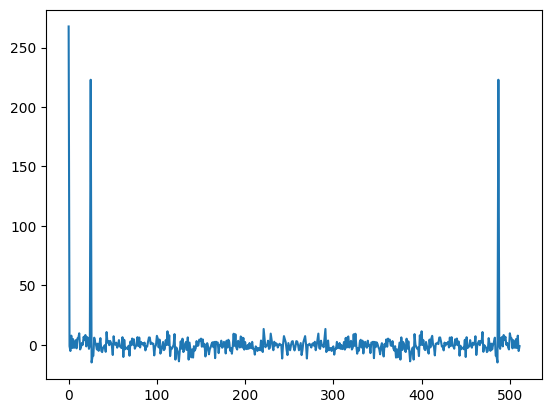

In [ ]:
plt.plot(np_fft.real)


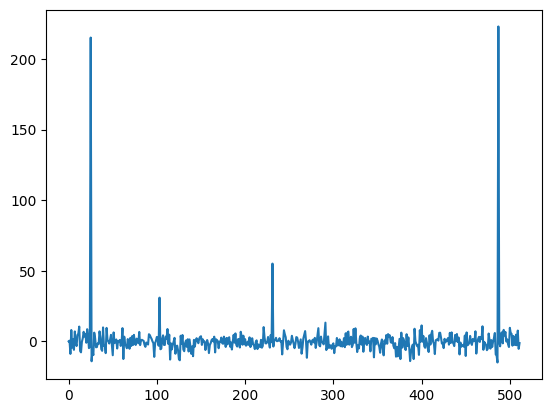

In [ ]:
plt.plot(result_array.real)


In [ ]:
def count_operations(signal, accumulators, unique_values):
    multiplies = 0
    additions = 0
    memory_accesses = 0

    for indices, acc_info in accumulators.items():
        for symbol_idx, positions in acc_info['positions'].items():
            for freq, part, pos in positions:
                # Count each operation:
                memory_accesses += 2  # Access signal and twiddle factor
                multiplies += 1       # signal * twiddle
                additions += 1        # accumulation

    return {
        'multiplies': multiplies,
        'additions': additions,
        'memory_accesses': memory_accesses
    }

print(count_operations(test_signal,sub_accumulators,unique_values))

{'multiplies': 1550336, 'additions': 1550336, 'memory_accesses': 3100672}


everything below this line is a work in process

In [ ]:
def extract_computation_sequence(accumulators, unique_values):
   # Create parallel arrays for our computation sequence
   positions = []
   twiddle_factors = []
   output_bins = []

   for indices, acc_info in accumulators.items():
       for symbol_idx, pos_list in acc_info['positions'].items():
           twiddle = unique_values[symbol_idx]
           for freq, part, pos in pos_list:
               positions.append(pos)
               twiddle_factors.append(twiddle)
               output_bins.append(freq)

   return (np.array(positions),
           np.array(twiddle_factors, dtype=np.complex128),
           np.array(output_bins))

# Extract sequence
pos_array, twiddle_array, bin_array = extract_computation_sequence(sub_accumulators, unique_values)
import numba
# Create Numba function
@numba.jit(nopython=True)
def ordered_dft_compute(signal, positions, twiddle_factors, output_bins):
   results = np.zeros(512, dtype=np.complex128)

   for i in range(len(positions)):
       pos = positions[i]
       twiddle = twiddle_factors[i]
       bin_idx = output_bins[i]
       results[bin_idx] += signal[pos] * twiddle

   return results

In [ ]:
then = time.time()
result = ordered_dft_compute(test_signal, pos_array, twiddle_array, bin_array)
print(time.time() - then)

0.009353160858154297


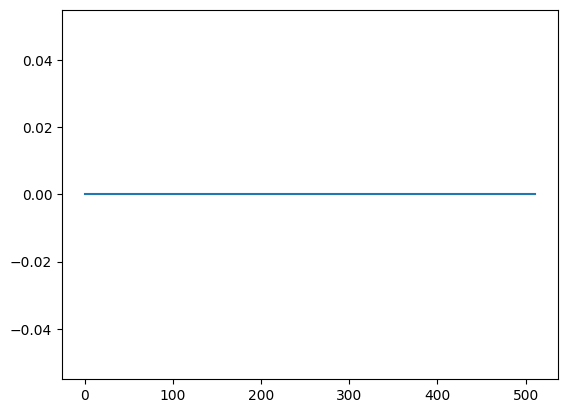

In [ ]:
plt.plot(result.imag)

In [ ]:
def extract_hierarchical_sequence(accumulators, unique_values):
    # Keep track of which accumulators feed into others
    computation_groups = []

    for indices, acc_info in accumulators.items():
        group = {
            'positions': [],
            'twiddles': [],
            'output_bins': [],
            'freqs': list(acc_info['freqs'])  # frequencies this group contributes to
        }

        for symbol_idx, pos_list in acc_info['positions'].items():
            twiddle = unique_values[symbol_idx]
            for freq, part, pos in pos_list:
                group['positions'].append(pos)
                group['twiddles'].append(twiddle)
                group['output_bins'].append(freq)

        computation_groups.append(group)

    return computation_groups

computation_groups = extract_hierarchical_sequence(sub_accumulators, unique_values)

@numba.jit(nopython=True)
def hierarchical_dft_compute(signal, computation_groups):
    results = np.zeros(512, dtype=np.complex128)

    for group in computation_groups:
        group_result = np.zeros(512, dtype=np.complex128)

        # Compute this group's contribution
        for i in range(len(group['positions'])):
            pos = group['positions'][i]
            twiddle = group['twiddles'][i]
            bin_idx = group['output_bins'][i]
            group_result[bin_idx] += signal[pos] * twiddle

        # Apply to appropriate frequency bins
        for freq in group['freqs']:
            results[freq] += group_result[freq]

    return results

result = hierarchical_dft_compute(test_signal, computation_groups)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
During: typing of argument at <ipython-input-119-f56583340b2f> (26)

File "<ipython-input-119-f56583340b2f>", line 26:
def extract_hierarchical_sequence(accumulators, unique_values):
    <source elided>

@numba.jit(nopython=True)
^ 

This error may have been caused by the following argument(s):
- argument 1: Cannot type list element type <class 'dict'>
